<a href="https://colab.research.google.com/github/Abishethvarman/FakeNewsDetection/blob/sentiment-analysis/V1.4.1.Sentiment_Analysis_TextBlob%2BVADER_FakeNews_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis on TEXTBLOB https://drive.google.com/drive/folders/1ya2UGUuTjE_YmNv9kw6F3vP-Cd-Up7H7

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import gensim
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

plt.style.use('ggplot')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 17APC3292
'17APC3292 (1).pdf'
'17APC3292 CA 2.m4a'
'17APC3292_final report _AMS.pdf'
'17APC3292_Form A.pdf'
'17APC3292_Form B_Signed.pdf'
'17APC3292_Form C-1.pdf'
'17APC3292_Form C-2.pdf'
'17APC3292_Form C-3.pdf'
'17APC3292_Form C-4.pdf'
'17APC3292_Form E (1).pdf'
'17APC3292_Form E.pdf'
 17APC3292_Industrial_Training_Presentation_V2_AV.pptx
 17APC3292_Industrial_Training_Report.pdf
 17APC3292_IS31229_Assignment.docx.pdf
'17APC3292_Mini Project final presentation template.pptx'
 17APC3292_Mini_Project_Final_Presentation_Trim.mp4
'17APC3292 - Mini Project Project Progress Journal 2021_editable_Forth phase AMS.pdf'
'17APC3292 - Mini Project Project Progress Journal 2021_editable_second phase MS.pdf'
'17APC3292 - Mini Project Project Progress Journal 2021_editable_Third phase AMS.pdf'
'17APC3292 - Mini Project Project Progress Journal 2021_editable till 30.12.2021 (1).pdf'
 17APC3292_mini-project-proposal.pdf
 17APC3292_Mini-Project-Prototype-Demonstration_Trim2

In [5]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [6]:
df=pd.read_csv("fake-20000-SA.csv")

In [7]:
df.head(3)

Unnamed: 0                                              title  \
0       10650   Trump Supporters Terrorize An American Woman ...   
1        2041  Trump adviser's Russia credentials come under ...   
2        8668  Turkey feels betrayed over EU accession but st...   

                                                text       subject  \
0  Donald Trump s deplorable supporters strike ag...          News   
1  MOSCOW (Reuters) - When Donald Trump named a l...  politicsNews   
2  LONDON (Reuters) - Turkey feels betrayed by so...     worldnews   

                  date  isfake label  
0     December 3, 2016       1  fake  
1     August 24, 2016        0  real  
2  September 14, 2017        0  real

In [8]:
print(df['subject'].unique())

['News' 'politicsNews' 'worldnews' 'politics' 'left-news'
 'Government News' 'Middle-east' 'US_News']


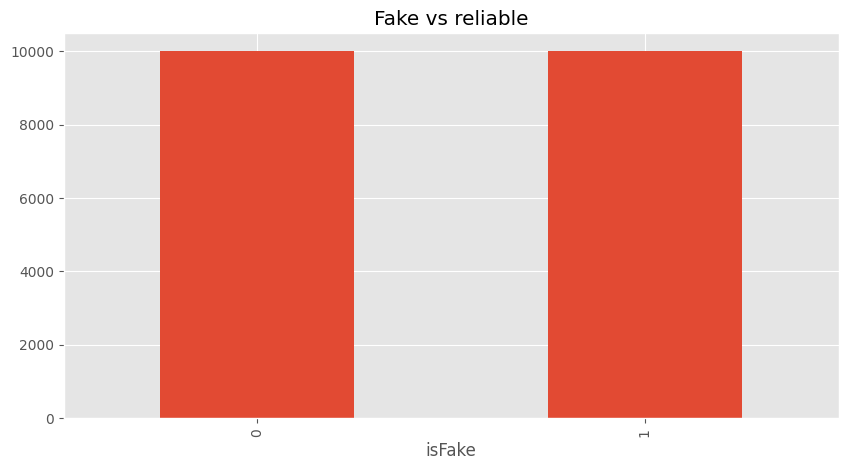

In [9]:
ax = df['isfake'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake vs reliable',
          figsize=(10, 5))
ax.set_xlabel('isFake')
plt.show()

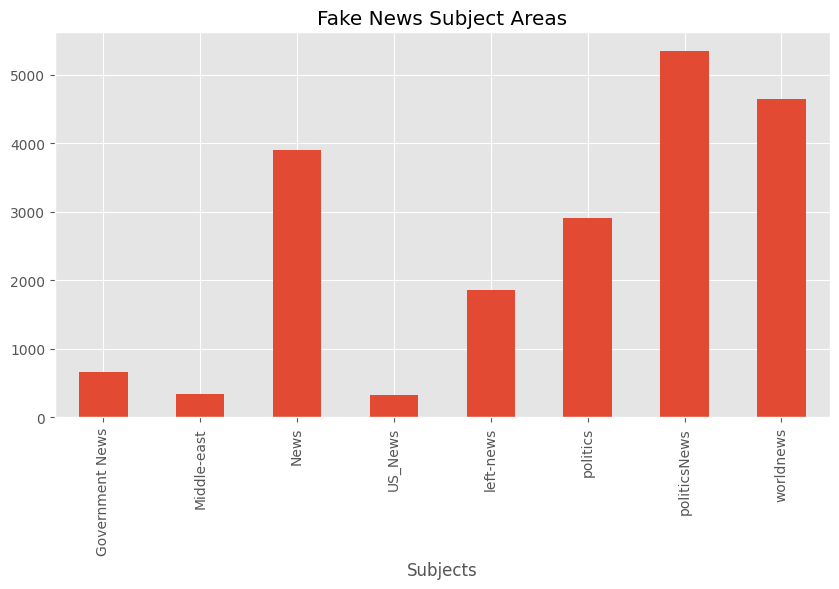

In [10]:
ax = df['subject'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake News Subject Areas',
          figsize=(10, 5))
ax.set_xlabel('Subjects')
plt.show()

In [11]:
df['original'] = df['title'] + ' ' + df['text']
df.head(3)

Unnamed: 0                                              title  \
0       10650   Trump Supporters Terrorize An American Woman ...   
1        2041  Trump adviser's Russia credentials come under ...   
2        8668  Turkey feels betrayed over EU accession but st...   

                                                text       subject  \
0  Donald Trump s deplorable supporters strike ag...          News   
1  MOSCOW (Reuters) - When Donald Trump named a l...  politicsNews   
2  LONDON (Reuters) - Turkey feels betrayed by so...     worldnews   

                  date  isfake label  \
0     December 3, 2016       1  fake   
1     August 24, 2016        0  real   
2  September 14, 2017        0  real   

                                            original  
0   Trump Supporters Terrorize An American Woman ...  
1  Trump adviser's Russia credentials come under ...  
2  Turkey feels betrayed over EU accession but st...

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'one', 'two', 'more','said','u','however','still','get','many','could'])

In [13]:
# Preprocessing
def preprocess(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() != 'mor']
    return ' '.join(filtered_words)

In [14]:
# Apply preprocessing
df['clean'] = df['original'].apply(preprocess)

In [15]:
print(df['clean'][0])

Trump Supporters Terrorize American Woman Subway Wearing Hijab Donald Trump deplorable supporters strike again.18-year-old Yasmin Seweid born Brooklyn , New York . raised America entire life . grew surrounded American culture values religious freedom guaranteed Constitution.And able wear hijab practice Islam.But standing subway platform waiting go home , three male Trump supporters targeted began harassing . called terrorist , ripped straps bag , tried forcibly remove hijab saying Trump name.The abuse continued train Seweid forced exit early stop order away . Bystanders even watched incident unfold cowardly nothing stop it.She reported incident police , investigating crime.In order warn others dangers Trump supporters , Seweid chose write horrific experience Facebook . take train every single day going & coming class , yesterday , something happened never thought would happen , Seweid wrote . harassed subway last night dehumanizing speak without getting emotional . Three white racists 

In [43]:
# test_df = df.iloc[:1000]
# train_df = df.iloc[:1000]

In [16]:
df['textblob_polarity'] = df['clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['textblob_subjectivity'] = df['clean'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['textblob_sentiment_score'] = df['textblob_polarity'].apply(lambda x: 1 if x >= 0 else 0)

In [17]:
df.head(2)

Unnamed: 0                                              title  \
0       10650   Trump Supporters Terrorize An American Woman ...   
1        2041  Trump adviser's Russia credentials come under ...   

                                                text       subject  \
0  Donald Trump s deplorable supporters strike ag...          News   
1  MOSCOW (Reuters) - When Donald Trump named a l...  politicsNews   

               date  isfake label  \
0  December 3, 2016       1  fake   
1  August 24, 2016        0  real   

                                            original  \
0   Trump Supporters Terrorize An American Woman ...   
1  Trump adviser's Russia credentials come under ...   

                                               clean  textblob_polarity  \
0  Trump Supporters Terrorize American Woman Subw...          -0.171620   
1  Trump adviser 's Russia credentials come scrut...           0.008896   

   textblob_subjectivity  textblob_sentiment_score  
0               0.521632                         0  
1               0.300606                         1

In [18]:
negative_threshold = -0.0125
positive_threshold = 0.0125

df['textblob_sentiment_on_polarity'] = pd.cut(
    df['textblob_polarity'],
    bins=[float('-inf'), negative_threshold, positive_threshold, float('inf')],
    labels=['negative', 'neutral', 'positive'],
    include_lowest=True
)

df.head(2)

Unnamed: 0                                              title  \
0       10650   Trump Supporters Terrorize An American Woman ...   
1        2041  Trump adviser's Russia credentials come under ...   

                                                text       subject  \
0  Donald Trump s deplorable supporters strike ag...          News   
1  MOSCOW (Reuters) - When Donald Trump named a l...  politicsNews   

               date  isfake label  \
0  December 3, 2016       1  fake   
1  August 24, 2016        0  real   

                                            original  \
0   Trump Supporters Terrorize An American Woman ...   
1  Trump adviser's Russia credentials come under ...   

                                               clean  textblob_polarity  \
0  Trump Supporters Terrorize American Woman Subw...          -0.171620   
1  Trump adviser 's Russia credentials come scrut...           0.008896   

   textblob_subjectivity  textblob_sentiment_score  \
0               0.521632                         0   
1               0.300606                         1   

  textblob_sentiment_on_polarity  
0                       negative  
1                        neutral

In [19]:
sentiment_mapping = {'negative': 0, 'positive': 1, 'neutral':-1}
df['textblob_sentiment_on_polarity_label'] = df['textblob_sentiment_on_polarity'].map(sentiment_mapping)
df.head(2)

Unnamed: 0                                              title  \
0       10650   Trump Supporters Terrorize An American Woman ...   
1        2041  Trump adviser's Russia credentials come under ...   

                                                text       subject  \
0  Donald Trump s deplorable supporters strike ag...          News   
1  MOSCOW (Reuters) - When Donald Trump named a l...  politicsNews   

               date  isfake label  \
0  December 3, 2016       1  fake   
1  August 24, 2016        0  real   

                                            original  \
0   Trump Supporters Terrorize An American Woman ...   
1  Trump adviser's Russia credentials come under ...   

                                               clean  textblob_polarity  \
0  Trump Supporters Terrorize American Woman Subw...          -0.171620   
1  Trump adviser 's Russia credentials come scrut...           0.008896   

   textblob_subjectivity  textblob_sentiment_score  \
0               0.521632                         0   
1               0.300606                         1   

  textblob_sentiment_on_polarity textblob_sentiment_on_polarity_label  
0                       negative                                    0  
1                        neutral                                   -1

In [20]:
accuracy = accuracy_score(df['textblob_sentiment_score'], df['textblob_sentiment_on_polarity_label'])
print(f"Accuracy on the entire DataFrame: {accuracy:.2f}")

Accuracy on the entire DataFrame: 0.87


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(df['textblob_sentiment_on_polarity_label'], df['textblob_sentiment_score'], average='micro')
recall = recall_score(df['textblob_sentiment_on_polarity_label'], df['textblob_sentiment_score'], average='micro')
f1 = f1_score(df['textblob_sentiment_on_polarity_label'], df['textblob_sentiment_score'], average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8740
Recall: 0.8740
F1 Score: 0.8740


In [45]:
test_sentiments = [TextBlob(article).sentiment.polarity for article in test_df['clean']]
test_sentiment_labels = [1 if score >= 0 else 0 for score in test_sentiments]

In [46]:
accuracy = accuracy_score(test_df['isfake'], train_sentiment_labels)
print(f"Accuracy on the testing set: {accuracy:.2f}")

Accuracy on the testing set: 0.47


In [38]:
accuracy = accuracy_score(train_df['isfake'], train_sentiment_labels)
print(f"Accuracy on the testing set: {accuracy:.2f}")

Accuracy on the testing set: 0.48


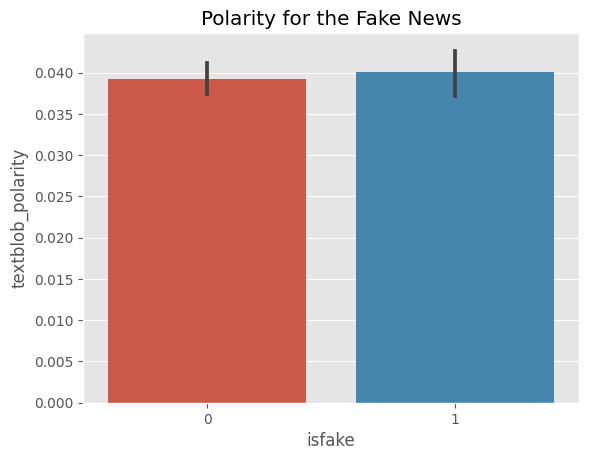

In [37]:
ax = sns.barplot(data=df, x='isfake', y='textblob_polarity')
ax.set_title('Polarity for the Fake News')
plt.show()

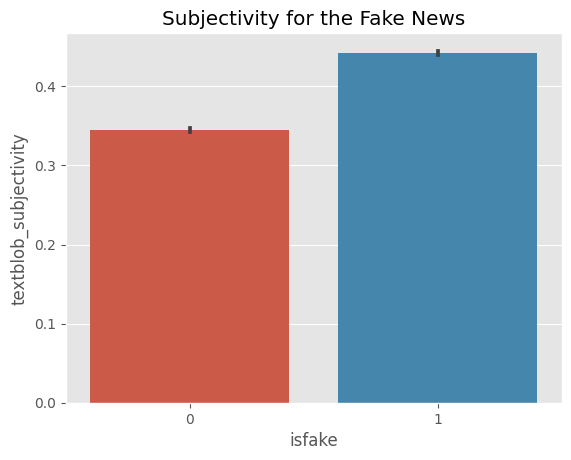

In [39]:
ax = sns.barplot(data=df, x='isfake', y='textblob_subjectivity')
ax.set_title('Subjectivity for the Fake News')
plt.show()

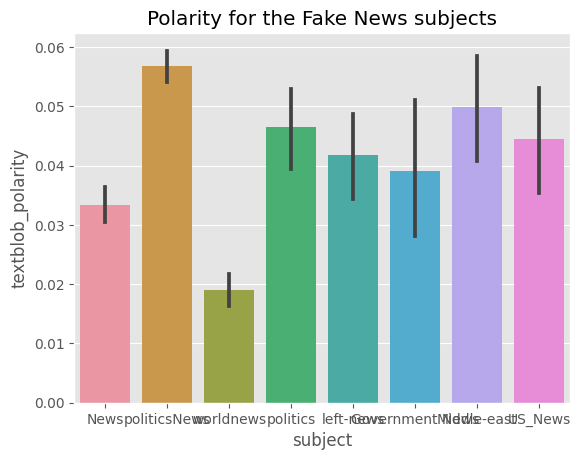

In [40]:
ax = sns.barplot(data=df, x='subject', y='textblob_polarity')
ax.set_title('Polarity for the Fake News subjects')
plt.show()

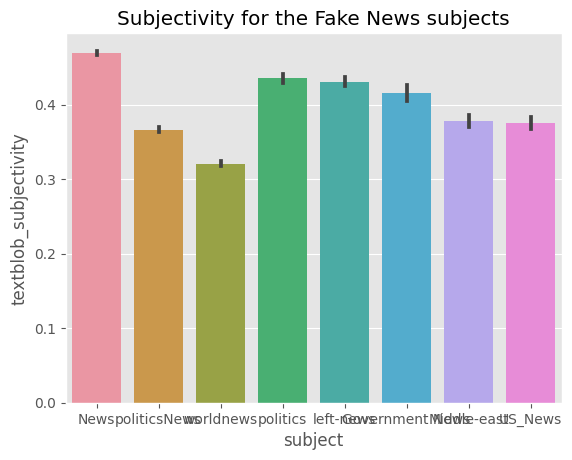

In [41]:
ax = sns.barplot(data=df, x='subject', y='textblob_subjectivity')
ax.set_title('Subjectivity for the Fake News subjects')
plt.show()

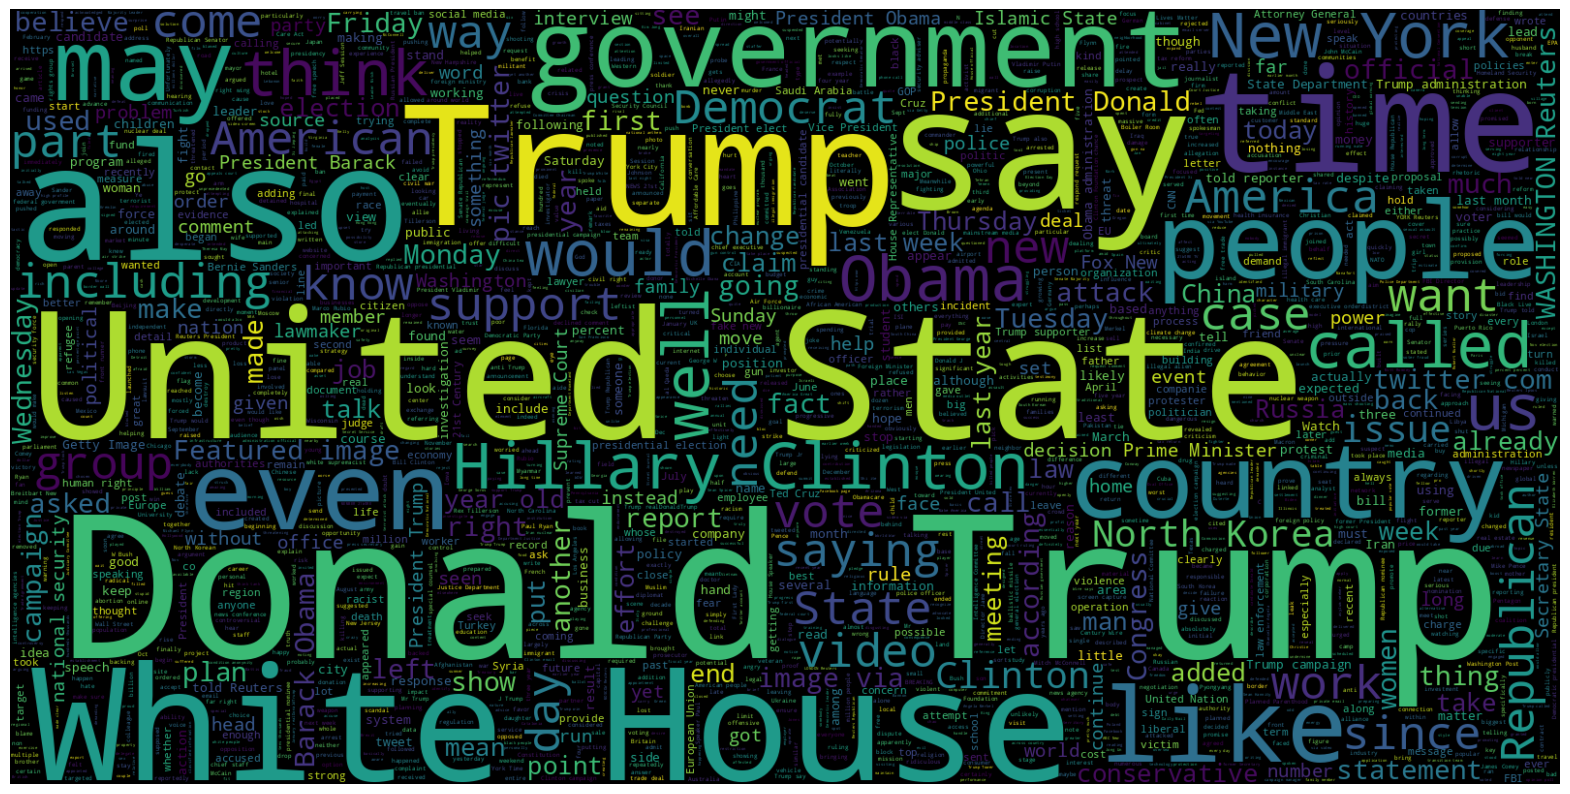

In [45]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df.clean))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

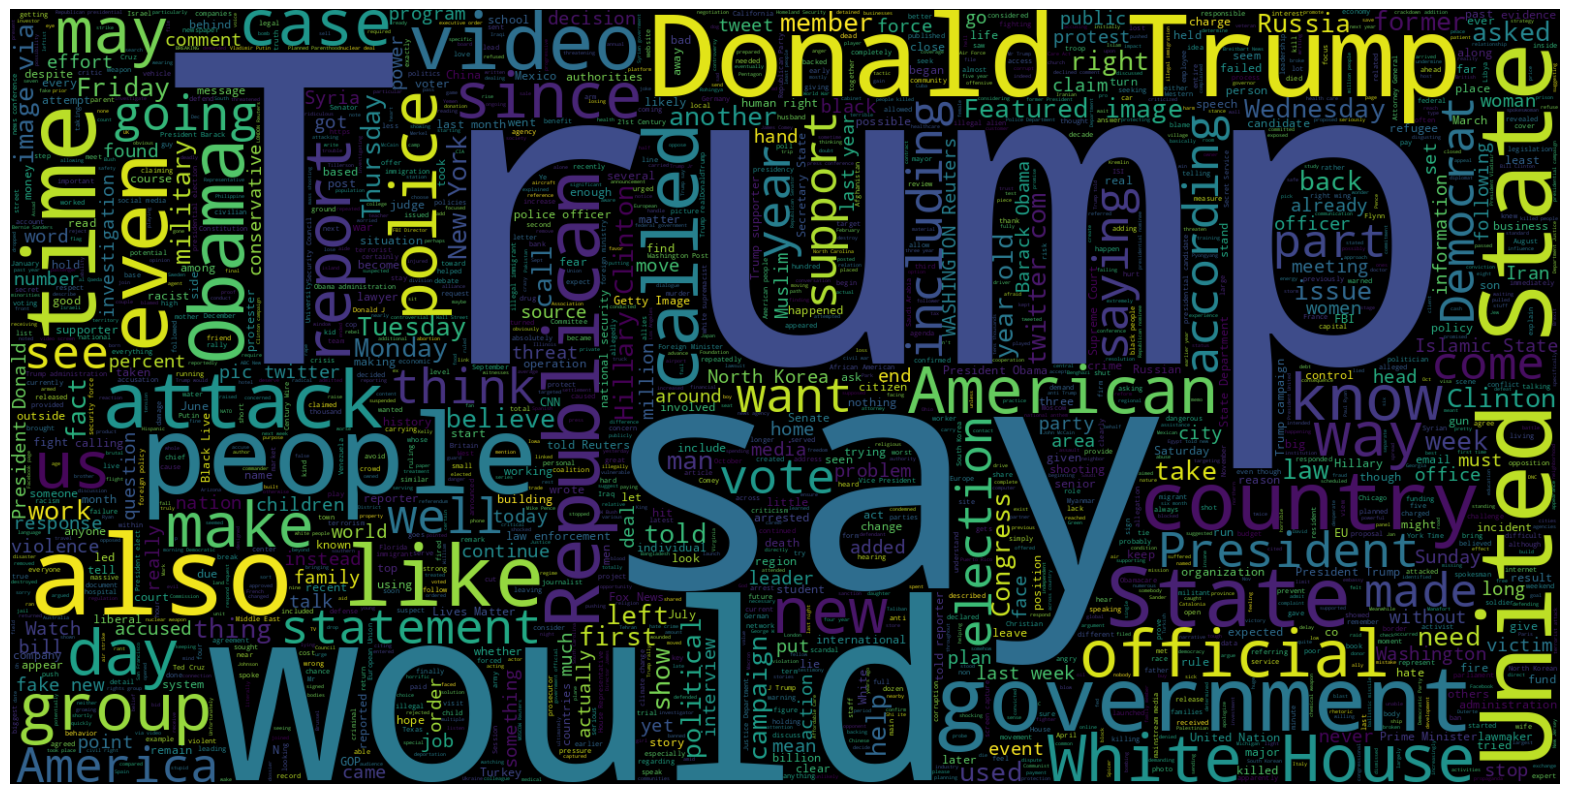

In [48]:
#negative sentiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.textblob_sentiment_score == 0].clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.show()

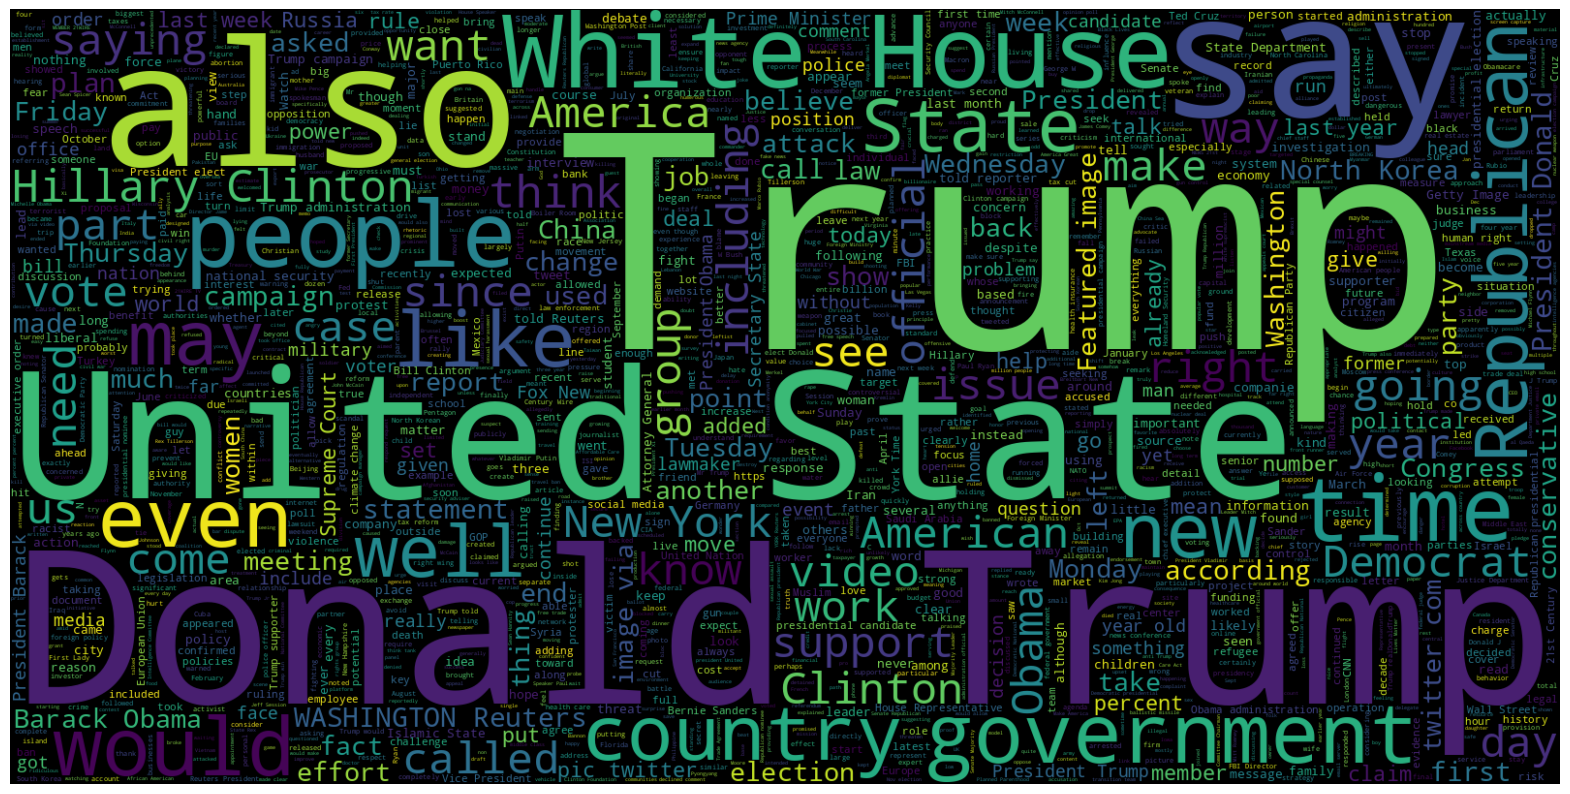

In [49]:
#positive sentiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.textblob_sentiment_score == 1].clean))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis("off")
plt.show()

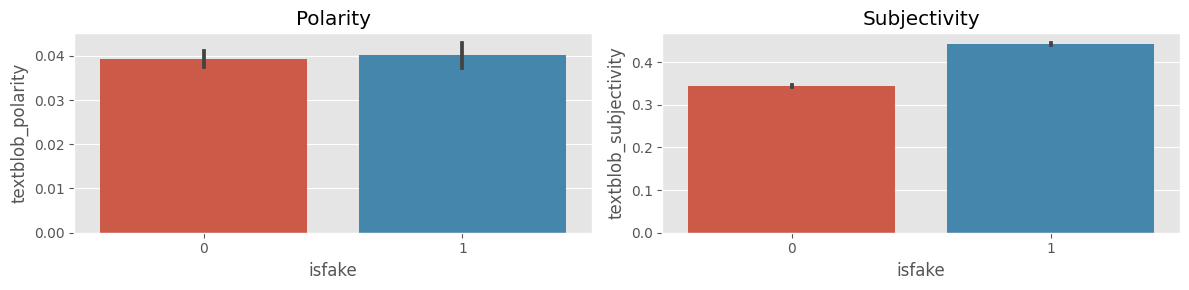

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
sns.barplot(data=df, x='isfake', y='textblob_polarity', ax=axs[0])
sns.barplot(data=df, x='isfake', y='textblob_subjectivity', ax=axs[1])
axs[0].set_title('Polarity')
axs[1].set_title('Subjectivity')
plt.tight_layout()
plt.show()

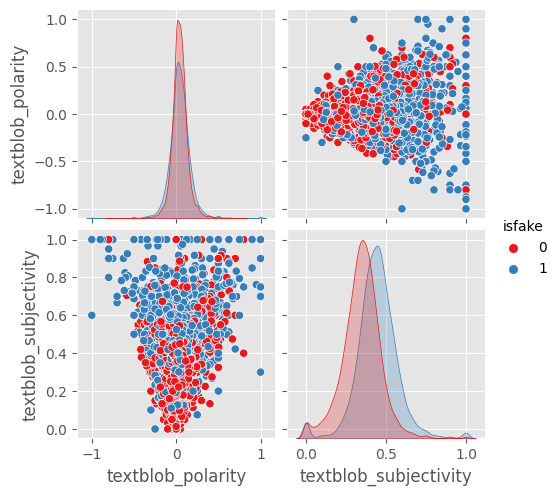

In [61]:
sns.pairplot(df, vars=['textblob_polarity', 'textblob_subjectivity'], hue='isfake', palette='Set1')
plt.show()

In [54]:
print(df['isfake'].unique())

[1 0]


In [58]:
print(df['textblob_sentiment_score'].unique())

[0 1]


In [59]:
print(df['textblob_sentiment_on_polarity_label'].unique())

[0, -1, 1]
Categories (3, int64): [0 < -1 < 1]
